In [24]:
#https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(edgeitems=2, linewidth=75)

In [3]:
# import training data
import  pandas as pd
#data = pd.read_csv('../data/co_channel.csv')
data = pd.read_csv('../data/green_channel.csv')

data.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


In [6]:
#observations
t_s = torch.tensor(data['stage']).float().unsqueeze(1)
t_q = torch.tensor(data['q']).float().unsqueeze(1)

#uncertainties
t_q_sigma = torch.tensor(data['q_sigma']).float().unsqueeze(1)
t_s_sigma = torch.tensor([0.01]).float().unsqueeze(1)

t_q.shape

torch.Size([36, 1])

In [11]:
def normalize(t):
    return (t - t.mean())/t.std()

In [93]:
t_s_ln = normalize(t_s.log())
t_q_ln = normalize(t_q.log())

In [8]:
t_s.mean()

tensor(4.1394)

In [41]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        super(MLP2, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)
    
    
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu', \
                 max_epoch=1000000, lr=0.0001, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        #self.model.cuda()
        self.criterion = nn.MSELoss()#.cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, X_train, y_train, verbose=True):
        X = X_train
        y = y_train
        #X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))#.cuda()
        #y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor))#.cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if verbose:
                if epoch == 1 or epoch % 1000 == 0:
                    print('Epoch {} loss: {}'.format(epoch+1, loss.data))##[0]))
        return self

In [86]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU and CUDA to run this section ###
'''
# Define networks
mlp2 = [MLP2Regressor(activation='relu'),
        MLP2Regressor(activation='tanh')]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(X_train, y_train,verbose=False) for mlp in mlp2]

# Save torch models
for ind, mlp in enumerate(mlp2):
    torch.save(mlp.model, 'co2_mlp2_'+str(ind)+'.pth')
'''

#hidden_layers = [528, 256, 256]
mpl2 = MLP2Regressor(hidden_layers=[528,528,528,528], droprate=0.2, max_epoch=5000, activation='relu')
mpl2.fit(t_s_ln, t_q_ln,verbose=True)

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=528, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=528, out_features=528, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (hidden2): Linear(in_features=528, out_features=528, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
    (hidden3): Linear(in_features=528, out_features=528, bias=True)
    (relu3): ReLU()
    (dropout4): Dropout(p=0.2, inplace=False)
    (final): Linear(in_features=528, out_features=1, bias=True)
  )
)
Epoch 1 loss: 0.04026956111192703
Epoch 2 loss: 0.028450442478060722
Epoch 1001 loss: 0.004851606208831072
Epoch 2001 loss: 0.004822164308279753
Epoch 3001 loss: 0.0059485603123903275
Epoch 4001 loss: 0.001707022194750607


In [88]:
def predict_reg(model, X, T=1000):
    #X = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
    model = model.model
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy()
    model = model.train()
    return y_pred, Yt_hat

In [89]:
y_relu_pred, y_hat = predict_reg(mpl2, t_s_ln)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)

In [90]:
s_n_range.numpy().flatten()

array([-0.7526815 , -0.50778115, -0.2628808 , -0.01798046,  0.22691989,
        0.47182024,  0.7167206 ,  0.9616209 ,  1.2065213 ,  1.4514216 ,
        1.696322  ,  1.9412223 ,  2.1861227 ,  2.4310231 ,  2.6759233 ,
        2.9208236 ,  3.1657243 ,  3.4106247 ,  3.6555252 ,  3.9004254 ],
      dtype=float32)

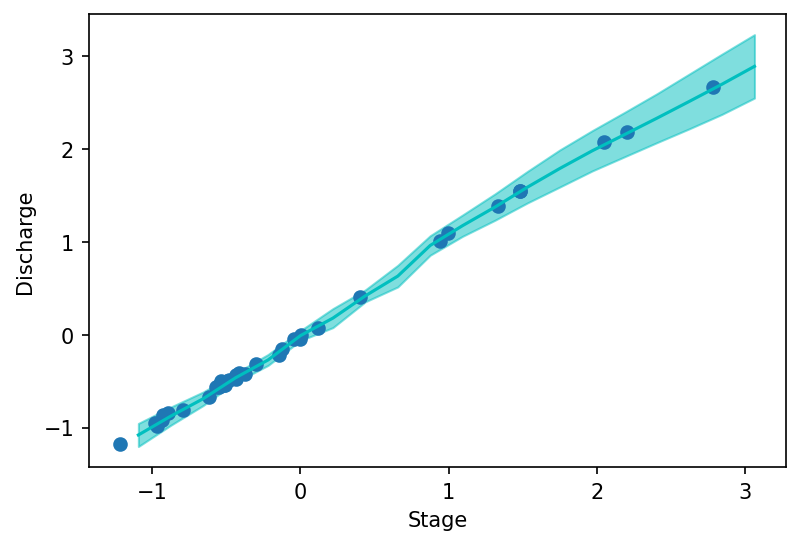

In [95]:
from matplotlib import pyplot as plt

s_n_range = torch.linspace(t_s_ln.min()*0.9, t_s_ln.max()*1.1, steps=20).unsqueeze(1)
s_n_relu_pred, y_hat = predict_reg(mpl2, s_n_range)
y_mu = y_hat.mean(axis=0)
y_std = y_hat.std(axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")


plt.plot(t_s_ln.numpy(), t_q_ln.numpy(), 'o')
plt.plot(s_n_range.numpy(), y_mu, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_mu + 1.96*y_std, y2=y_mu - 1.96*y_std, alpha=0.5, color='c')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [112]:
#t_s_ln = normalize(t_s.log())
#t_q_ln = normalize(t_q.log())
t_s_ln = normalize(t_s)
t_q_ln = normalize(t_q)

In [113]:

#hidden_layers = [256, 256, 256]
hidden_layers = [1056, 1056] # loss 0.0028
hidden_layers = [528, 528, 528]
mpl2 = MLP2Regressor(hidden_layers=hidden_layers, droprate=0.2, max_epoch=5000, activation='relu')
mpl2.fit(t_s_ln, t_q_ln,verbose=True)

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=528, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=528, out_features=528, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (hidden2): Linear(in_features=528, out_features=528, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
    (final): Linear(in_features=528, out_features=1, bias=True)
  )
)
Epoch 1 loss: 1.0297777652740479
Epoch 2 loss: 0.845386266708374
Epoch 1001 loss: 0.00432015024125576
Epoch 2001 loss: 0.004948774352669716
Epoch 3001 loss: 0.0038156243972480297
Epoch 4001 loss: 0.0015667579136788845


In [117]:
y_relu_pr

array([[ 1.028685  ],
       [-0.03969652],
       [-0.36374798],
       [-0.37169698],
       [-0.36844656],
       [-0.34731856],
       [-0.4437214 ],
       [-0.43174955],
       [-0.38453192],
       [-0.27423403],
       [ 2.2601333 ],
       [ 0.39554557],
       [-0.47916538],
       [-0.3337981 ],
       [-0.34731856],
       [-0.43777737],
       [-0.41567588],
       [-0.36531225],
       [-0.35734996],
       [ 0.80541587],
       [-0.18876538],
       [-0.37332806],
       [-0.37496075],
       [-0.23422897],
       [-0.27972478],
       [-0.23189057],
       [-0.3422137 ],
       [-0.24791995],
       [ 1.9693428 ],
       [ 1.0235475 ],
       [ 0.44690812],
       [-0.31709173],
       [-0.36054426],
       [-0.43928382],
       [-0.44662663],
       [ 3.6401036 ]], dtype=float32)

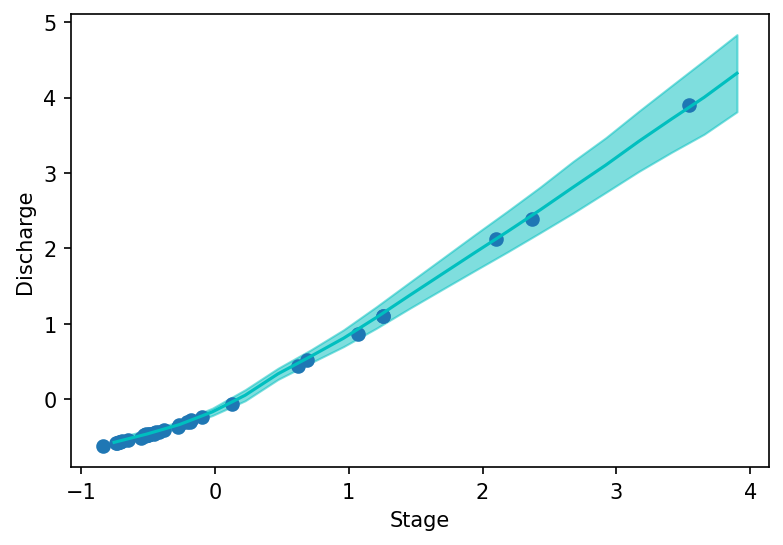

In [114]:
y_relu_pred, y_hat = predict_reg(mpl2, t_s_ln)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)

from matplotlib import pyplot as plt

s_n_range = torch.linspace(t_s_ln.min()*0.9, t_s_ln.max()*1.1, steps=20).unsqueeze(1)
s_n_relu_pred, y_hat = predict_reg(mpl2, s_n_range)
y_mu = y_hat.mean(axis=0)
y_std = y_hat.std(axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")


plt.plot(t_s_ln.numpy(), t_q_ln.numpy(), 'o')
plt.plot(s_n_range.numpy(), y_mu, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_mu + 1.96*y_std, y2=y_mu - 1.96*y_std, alpha=0.5, color='c')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [ ]:
t_s